In [1]:
# !conda install -c conda-forge -y --force-reinstall python==3.11.5
# !pip install --extra-index-url https://pypi.nvidia.com cudf-cu12
# !pip install --extra-index-url https://pypi.nvidia.com cuml-cu12

In [7]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

In [ ]:
###### Modeling and Explainability

In [1]:
###### https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/ #################
# with modifications and GPU acceleration by Mark J Bennett mbennett@nvidia.com and Emanuel Scoullos escoullos@nvidia.com

###### Best when compared to:
###### https://www.bankofengland.co.uk/-/media/boe/files/working-paper/2019/
######        machine-learning-explainability-in-finance-an-application-to-default-risk-analysis.pdf
%matplotlib inline
import time
total_start = time.time()
from collections import OrderedDict
import gc
import glob
import os
import pickle
import re
import sys

from typing import Union

import cudf
import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, precision_recall_curve, f1_score, 
                             accuracy_score)

from tqdm.autonotebook import tqdm
import xgboost as xgb

/tmp/ipykernel_11064/937460551.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
##############
##############
use_cpu = False  # whether to use CPU or GPU

##############
##############

if use_cpu:
    print('using CPU')
    from pandas import read_parquet, concat, merge, DataFrame, get_dummies, Series, isnull
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from numpy import zeros, double, int8, int16, int64, concatenate, argmax, argmin
else:
    print('using GPU')
    from cudf import read_parquet, concat, merge, DataFrame, get_dummies, Series
    from cupy import zeros,double, int8, int16, int64, concatenate, argmax, argmin
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import OneHotEncoder, StandardScaler
    from cuml.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score
    
import shap

from clfmodel import binaryClassification

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# make sure the path below points to the data directory where the FannieMae data was downloaded.
clean_data_path = './rapids/notebooks/cleaned_data'
figures_path = './rapids/notebooks/figures'
os.makedirs(figures_path, exist_ok=True)

using GPU


In [3]:
def cupy2numpy(obj, use_cpu):
    if use_cpu and isinstance(obj, cp._core.core.ndarray):
        return obj.get()
    elif use_cpu and isinstance(obj, cudf.core.series.Series):
        return obj.to_array()
    return obj

In [5]:
with open(f'{clean_data_path}/fnma_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
print('\n'.join(mappings.keys()))

Channel
SellerName
FTHomeBuyer
LoanPurpose
PropertyType
OccStatus
PropertyState
Zip
ProductType
MortInsType


In [ ]:
###### Read cleaned FannieMae Dataset from notebook 1

In [6]:
df = read_parquet(f'{clean_data_path}/fnma_cleaned.pq')

In [7]:
type(df), df.shape

(cudf.core.dataframe.DataFrame, (11248077, 22))

In [8]:
Xcolumns=['Channel',
         'SellerName',
         'OrInterestRate',
         'OrUnpaidPrinc',
         'OrLoanTerm',
         'OrCLTV',
         'NumBorrow',
         'DTIRat',
         'CreditScore',
         'FTHomeBuyer',
         'LoanPurpose',
         'PropertyType',
         'NumUnits',
         'OccStatus',
         'PropertyState',
         'Zip',
         'ProductType',
         'CoCreditScore',
         'Extra',
         'MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 
                      'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

In [9]:
###### Predicting Delinquent Loans

In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

y = df['Default']#.values
X = df.drop(['Default','LoanID'], axis=1)#.values
Xcolumns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=11)
X_train = X_train[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]
X_test = X_test[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]

In [12]:
print(X_train.shape, y_train.shape)
print(y_train.sum(), y_test.sum())

(10123270, 20) (10123270,)
14183 1535


In [13]:
X_train.head()

,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,PropertyState,PropertyType,SellerName,Zip,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
9095777,1.0,1.0,1.0,0.0,0.0,0.0,12.0,1.0,3.0,16.0,4.125000,386000.000000,360.000000,80.000000,1.000000,24.000000,794.000000,1.000000,766.868035,1.077555
5590064,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,8.0,720.0,5.250000,252000.000000,360.000000,86.000000,2.000000,42.000000,752.000000,1.000000,799.000000,1.077555
10990690,0.0,0.0,1.0,0.0,0.0,0.0,48.0,1.0,4.0,266.0,3.500000,231000.000000,360.000000,93.000000,1.000000,35.000000,790.000000,1.000000,766.868035,1.000000
11239914,1.0,0.0,2.0,0.0,0.0,0.0,12.0,0.0,2.0,41.0,4.820304,216744.602536,306.703223,69.215426,1.588281,33.175486,758.225989,1.030218,766.868035,1.077555
10886123,0.0,0.0,2.0,0.0,0.0,0.0,24.0,0.0,27.0,439.0,2.500000,98000.000000,180.000000,37.000000,1.000000,46.000000,805.000000,1.000000,766.868035,1.077555


In [14]:
data_prep_time = time.time()

In [15]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', save_path=None, cmap=plt.cm.cool):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)

In [16]:
##### XGBoost
##### Alright, now we’re ready to make some predictions! We first randomly split the data into a training set and a test set using the Scikit-Learn train_test_split_function. From these two sets, we idenfiy the target (“Default”) vector, and feature arrays.

In [17]:
y_train.sum()/len(y_train)

0.0014010295092396034

In [18]:
scaling = (len(y_train)-y_train.sum())/y_train.sum()
scaling = float(scaling)

print('scaling:', scaling )   

scaling: 712.7608404427837


In [19]:
# parameters here are not optimized. Feel free to experiment!
params = {
    'num_rounds':        100,
    'max_depth':         12,
    'max_leaves':        0,
    'alpha':             3,
    'lambda':            1,
    'eta':               0.17,
    'subsample':         1,
    'sampling_method':   'gradient_based',
    'scale_pos_weight':  scaling,
    'max_delta_step':    1,
    'max_bin':           2048,
    'tree_method':       'gpu_hist',
    'grow_policy':       'lossguide',
    'n_gpus':            1,
    'objective':         'binary:logistic',#'binary:hinge'
    'eval_metric':       'aucpr',#'error',#'auc', 'logloss'
    'predictor':         'gpu_predictor',
    'num_parallel_tree': 1,
    "min_child_weight":  2,
    'verbose':           True
}

if use_cpu:
    print('training XGBoost model on cpu')
    params['tree_method'] = 'hist'
    params['sampling_method'] = 'uniform'
    params['predictor'] = 'cpu_predictor'

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
    
evals = [(dtest, 'test'), (dtrain, 'train')]

In [21]:
start = time.time()

model = xgb.train(params, dtrain, params['num_rounds'], evals=evals,
                          early_stopping_rounds=10)
print(f'Elapsed time: {time.time() - start: 0.3f} s')

/home/opc/miniconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:21:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/opc/miniconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:21:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_gpus", "num_rounds", "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-aucpr:1.00000	train-aucpr:1.00000
[1]	test-aucpr:1.00000	train-aucpr:1.00000
[2]	test-aucpr:1.00000	train-aucpr:1.00000
[3]	test-aucpr:1.00000	train-aucpr:1.00000
[4]	test-aucpr:1.00000	train-aucpr:1.00000
[5]	test-aucpr:1.00000	train-aucpr:1.00000
[6]	test-aucpr:1.00000	train-aucpr:1.00000
[7]	test-aucpr:1.00000	train-aucpr:1.00000
[8]	test-aucpr:1.00000	train-aucpr:1.00000
[9]	test-aucpr:1.00000	train-aucpr:1.00000
Elapsed time:  0.719 s


In [22]:
model.save_model(f'{clean_data_path}/xgb_model')

/home/opc/miniconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:22:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/opc/miniconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:22:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [23]:
# make predictions on the test set using our trained model
cp.cuda.Device(0).use()
use_f1_measure = True

preds = model.predict(dtest)
if isinstance(preds, np.ndarray) and not use_cpu:
    preds = cp.array(preds)
    
true_labels = y_test.astype(int).values.squeeze()
true_labels = cupy2numpy(true_labels, use_cpu)
precision, recall, thresholds = precision_recall_curve(true_labels, preds)

if use_f1_measure:
    # apply the threshold using F1 measure to the prediction.
    threshold_idx = cupy2numpy(np.argmax((2 * precision * recall)/ (precision + recall+1e-7)), True)
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
else:
    # apply the threshold TPR-FPR to the prediction.
    fpr, tpr, thresholds = roc_curve(cupy2numpy(true_labels, True), cupy2numpy(preds, True))
    threshold_idx = cupy2numpy(np.argmax(tpr - fpr), True)
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
    print(f'TPR: {tpr[threshold_idx]: 0.4f}')
    print(f'FPR: {fpr[threshold_idx]: 0.4f}')
    
    
print(f'Threshold: {thresholds[threshold_idx]: 0.4f}')
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
print('Predicted', pred_labels.sum())
print('Actual', true_labels.sum())
# compute the auc, this should match the last test auc output above
#
auc_measure = roc_auc_score(true_labels, preds)

print(f'AUC {auc_measure: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {(2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx]): 0.4f}')
recall = cupy2numpy(recall, True)
precision = cupy2numpy(precision, True)
# area under precision recall curve
auprc= auc(recall, precision)
print(f'AUPRC: {auprc: 0.4f}')

/home/opc/miniconda3/lib/python3.11/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


Threshold:  0.8665
Precision:  1.0000
Recall:  1.0000
Predicted 1535
Actual 1535
AUC  1.0000
Accuracy:  1.0000
F1:  1.0000
AUPRC:  1.0000


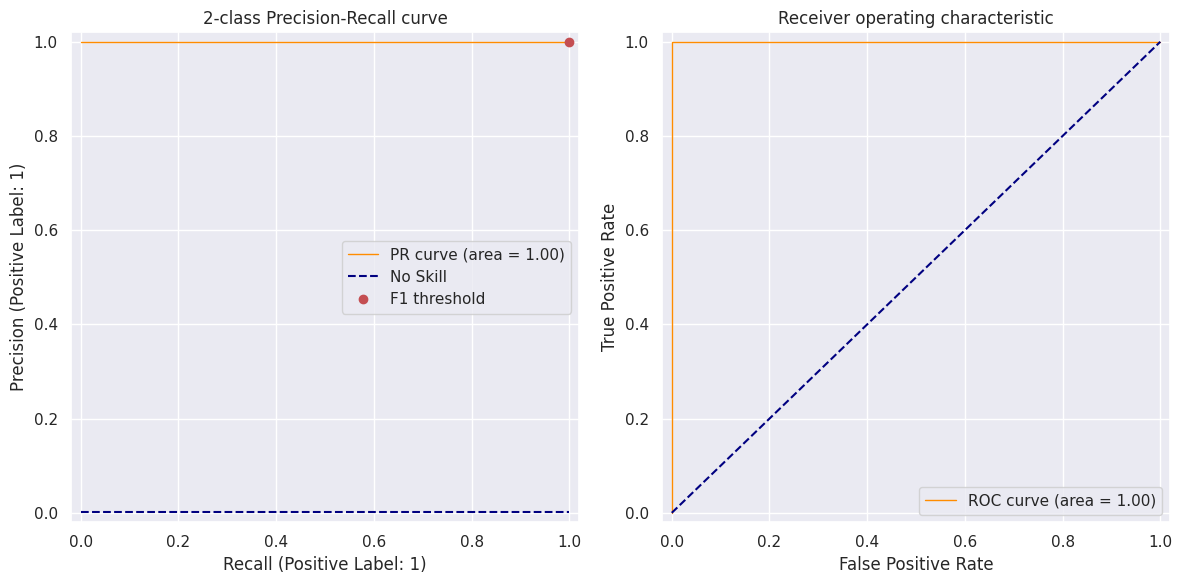

In [24]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
no_skill = y_test.sum()/len(y_test)
ax[0].plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auprc)
ax[0].plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')

ax[0].plot(recall[threshold_idx],
           precision[threshold_idx], 'ro', label='F1 threshold')

ax[0].set_xlabel('Recall (Positive Label: 1)')
ax[0].set_ylabel('Precision (Positive Label: 1)')
ax[0].set_title('2-class Precision-Recall curve')
ax[0].set_xlim([-0.02, 1.02])
ax[0].set_ylim([-0.02, 1.02])
ax[0].legend()

fpr, tpr, thresholds = roc_curve(cupy2numpy(true_labels, True), cupy2numpy(preds, True))
# roc_auc = roc_auc_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, preds)
ax[1].plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([-0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_xlim([-0.02, 1.02])
ax[1].set_ylim([-0.02, 1.02])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")
plt.tight_layout()
plt.savefig(f'{figures_path}/xgb_pr_roc_curves.png', dpi=600)

Confusion Matrix :


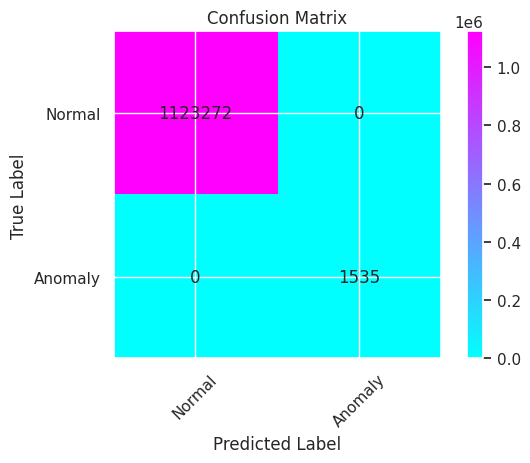

In [25]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)

print ('Confusion Matrix :')

plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/xgb_confusion_matrix.png')


In [26]:
len(true_labels), len(y_test)

(1124807, 1124807)

In [27]:
type(pred_labels)

cupy.ndarray

In [28]:
# flag
print("Classification Report for XGBoost Classifier: \n", 
      classification_report(cupy2numpy(y_test, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))
print("Confusion Matrix of XGBoost Classifier: \n", 
      confusion_matrix(cupy2numpy(y_test, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))


AttributeError: 'Series' object has no attribute 'to_array'

In [29]:
###  Explainability with Shap

In [30]:
shap_time = time.time()

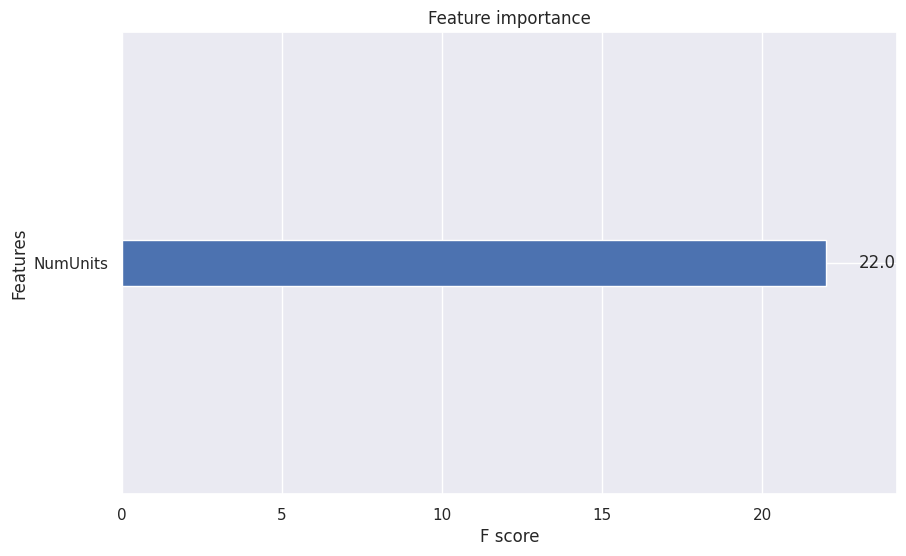

In [31]:
x = plt.rcParams["figure.figsize"] = [10,6]
fig, ax = plt.subplots()
xgb.plot_importance(model, max_num_features=10, ax = ax)
plt.savefig(f'{figures_path}/xgb_feat_importance.png', dpi=600)

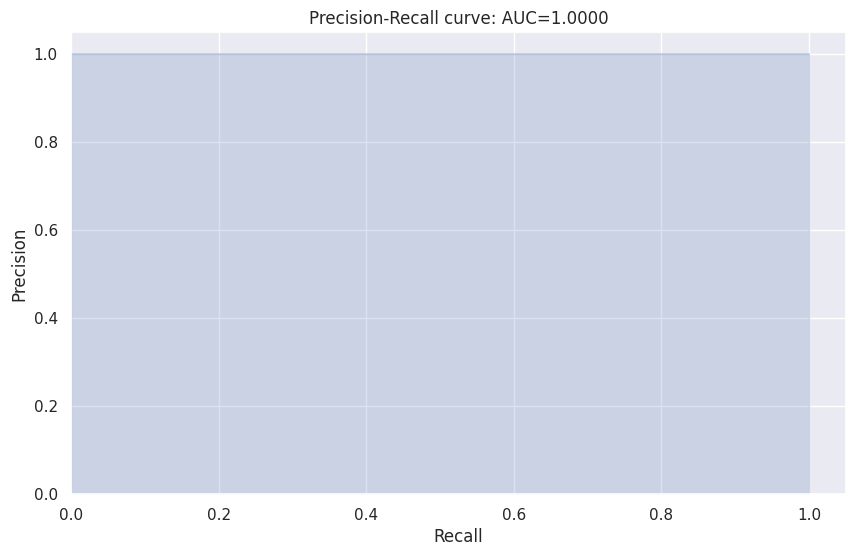

In [32]:
# Function for plotting Precision Recall curve and measuring AUC
def plot_precision_recall(y_test: np.array, y_score: np.array, isPR = True) -> None:
    #print(y_test[0:20],y_score[0:20])
    precision, recall, _ = precision_recall_curve(y_test, y_score) if isPR else roc_curve(y_test, y_score)
    auc_score = auc(recall, precision)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

plt.rcParams["figure.figsize"] = [10,6]
plot_precision_recall(cupy2numpy(y_test.values, not use_cpu), cupy2numpy(preds, True))

In [33]:
## shap Tree Explainer
start = time.time()
    
expl = shap.TreeExplainer(model)
shap_values = expl.shap_values(X_test)
tshap = time.time()-start
print(f'Elapsed: {time.time()-start: 0.4f} sec')
print(shap_values.shape)
print(f'XGBoost version: {xgb.__version__}')

start = time.time()
sns.set()

Elapsed:  0.1264 sec
(1124807, 20)
XGBoost version: 2.1.0


In [36]:
np.save(f'{clean_data_path}/xgb_shap.npy', shap_values)

In [37]:
# save for dashboarding
X_train.to_parquet(f'{clean_data_path}/xgb_xtrain.parquet')
y_train.to_frame().to_parquet(f'{clean_data_path}/xgb_ytrain.parquet')

X_test.to_parquet(f'{clean_data_path}/xgb_xtest.parquet')
y_test.to_frame().to_parquet(f'{clean_data_path}/xgb_ytest.parquet')

In [38]:
if False:
  if use_cpu: 
    shap.summary_plot(shap_values, X_test)
  else: 
    shap.summary_plot(shap_values, X_test.to_pandas(), sort=False, show=False)
    
  plt.tight_layout()

if False:
    ax = f.gca()
    ax.set_xlim([-5, 5])

    f = plt.gcf()
    f.savefig(f'{figures_path}/Shap_XGBoost_1200.png', dpi=6000)
    print(f'Elapsed: {time.time()-start: 0.4f} sec')

In [39]:
##### PyTorch

import torch
import torch.nn as nn
import torch.optim as optim

EPOCHS = 20
BATCH_SIZE = 2048
LEARNING_RATE = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() and not use_cpu else "cpu")
print(device)

cuda:0


In [41]:
pyt_time = time.time()
print(pyt_time)

1721381216.8450537


In [42]:
Xcolumns=['Channel',
         'SellerName',
         'OrInterestRate',
         'OrUnpaidPrinc',
         'OrLoanTerm',
         'OrCLTV',
         'NumBorrow',
         'DTIRat',
         'CreditScore',
         'FTHomeBuyer',
         'LoanPurpose',
         'PropertyType',
         'NumUnits',
         'OccStatus',
         'PropertyState',
         'Zip',
         'ProductType',
         'CoCreditScore',
         'Extra',
         'MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 
                      'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

In [43]:
##### Scale numerical data

In [44]:
std_scaler = StandardScaler()

In [45]:
X_train[CONTINUOUS_COLUMNS].head()

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
9095777,4.125000,386000.000000,360.000000,80.000000,1.000000,24.000000,794.000000,1.000000,766.868035,1.077555
5590064,5.250000,252000.000000,360.000000,86.000000,2.000000,42.000000,752.000000,1.000000,799.000000,1.077555
10990690,3.500000,231000.000000,360.000000,93.000000,1.000000,35.000000,790.000000,1.000000,766.868035,1.000000
11239914,4.820304,216744.602536,306.703223,69.215426,1.588281,33.175486,758.225989,1.030218,766.868035,1.077555
10886123,2.500000,98000.000000,180.000000,37.000000,1.000000,46.000000,805.000000,1.000000,766.868035,1.077555


In [46]:
# fit and transform data on train set
scaled_col_data = std_scaler.fit_transform(X_train[CONTINUOUS_COLUMNS])

if not use_cpu:
    scaled_col_data = scaled_col_data.values

for col_num, col in enumerate(CONTINUOUS_COLUMNS):
    X_train[col] = scaled_col_data[:, col_num]

del scaled_col_data
X_train[CONTINUOUS_COLUMNS].head()

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
9095777,-0.679839,1.363902,0.640855,0.625094,-1.166797,-0.813833,0.752115,-0.132978,0.000193,-0.000102
5590064,0.420215,0.284004,0.640855,0.972869,0.816311,0.782411,-0.130757,-0.132978,1.013063,-0.000102
10990690,-1.290981,0.114766,0.640855,1.378606,-1.166797,0.161650,0.668032,-0.132978,0.000193,-0.830916
11239914,0.000047,-0.000117,0.000036,-0.000007,-0.000172,-0.000149,0.000118,-0.000139,0.000193,-0.000102
10886123,-2.268807,-0.957073,-1.523394,-1.867293,-1.166797,1.137132,0.983343,-0.132978,0.000193,-0.000102


In [47]:
X_train[CONTINUOUS_COLUMNS].isna().sum(), X_test[CONTINUOUS_COLUMNS].isna().sum()

(OrInterestRate    0
 OrUnpaidPrinc     0
 OrLoanTerm        0
 OrCLTV            0
 NumBorrow         0
 DTIRat            0
 CreditScore       0
 NumUnits          0
 CoCreditScore     0
 Extra             0
 dtype: int64,
 OrInterestRate    0
 OrUnpaidPrinc     0
 OrLoanTerm        0
 OrCLTV            0
 NumBorrow         0
 DTIRat            0
 CreditScore       0
 NumUnits          0
 CoCreditScore     0
 Extra             0
 dtype: int64)

In [48]:
# transform data on test set
test_scaled_col_data = std_scaler.transform(X_test[CONTINUOUS_COLUMNS])
if not use_cpu:
    test_scaled_col_data = test_scaled_col_data.values
    
for col_num, col in enumerate(CONTINUOUS_COLUMNS):
    X_test[col] = test_scaled_col_data[:, col_num]
del test_scaled_col_data

In [49]:
y_train

9095777     0
5590064     0
10990690    0
11239914    1
10886123    0
           ..
2879262     0
6477230     0
9317221     0
2801346     0
437252      0
Name: Default, Length: 10123270, dtype: int64

In [50]:
###### Model Definition
cards = []
for key in sorted(mappings):
    print(key, len(set(mappings[key])))
    cards.append(len(set(mappings[key])))

Channel 3
FTHomeBuyer 3
LoanPurpose 4
MortInsType 2
OccStatus 3
ProductType 1
PropertyState 54
PropertyType 5
SellerName 49
Zip 961


In [51]:
def save_checkpoint(model, optimizer, epoch: int, best_score, file_name, threshold, save_path: str, k_fold=0):
    """
    Save checkpoint to pytorch .pt file.
    Args:
        model: Instance of Pytorch model.
        optimizer: pytorch optimizer ex. torch.optim.Adam() instance
        epoch: epoch number
        best_score: model best score acccoring to appropriate metric.
                    Can be multiple, just save as a dict. of {'metric': score}
        k_fold: int or string for K-folds.
        file_name (str): filename usually including the name of the model.:

    Returns:

    """
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'k_fold': k_fold,
        'epoch': epoch,
        'best_score': best_score,
        'threshold': threshold
    }
    if not save_path:
        save_path = '.'
    os.makedirs(f'{save_path}/checkpoints/', exist_ok=True)

    torch.save(checkpoint, f'{save_path}/checkpoints/{file_name}.pt')


def load_checkpoint(file_name: str, model, device: str, save_path: str):
    """
    Load Checkpoint from pytorch .pt file.

    Args:
        device: str
        file_name (str): filename usually including the name of the model.
        model_cls: (uninstantiated) class belonging to a custom nn.Module
        **kwargs:

    Returns:

    """
    # instantiate the model and pass in input params as kwargs.
    model = model.to(device)
    if not save_path:
        save_path = '.'
    checkpoint = torch.load(f'{save_path}/checkpoints/{file_name}.pt')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model, checkpoint['threshold']

In [52]:
def train_epoch(model, loader, optimizer, loss_func, metric, device, epoch=''):
    model.train()
    model.zero_grad()
    train_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    train_acc = torch.zeros(len(loader), requires_grad=False, device=device)
    batch = 0
    pbar = tqdm(loader)
    
    train_logits = []
    train_targets = []
    

    for x_cat, x_cont, target in pbar:
        # make prediction
        logits = model(x_cat, x_cont).squeeze()
        
        # calculate loss
        loss = loss_func(logits, target)  # criterion
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
        
        train_loss[batch] = loss.detach()
        train_acc[batch] = metric(logits, target)
        
        train_targets.append(target.detach())
        train_logits.append(logits.detach())
        
        batch += 1
        if batch == len(loader) or not batch %100:
            pbar.set_description(f'Epoch: {epoch} mean loss {train_loss[:batch].mean().cpu(): 0.5f}, ' 
                                 f'mean acc: {train_acc[:batch].mean().cpu(): 0.5f}')
        
    return train_loss, train_logits, train_targets  


def val_epoch(model, loader, loss_func, device):
    model.eval()
    val_logits = []
    val_targets = []
    val_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    
    with torch.no_grad():
        batch=0
        for x_cat, x_cont, target in tqdm(iter(loader)):
            # make prediction
            logits = model(x_cat, x_cont).squeeze()
            
            # calculate loss
            loss = loss_func(logits, target)  # criterion
            
            # save some data
            val_targets.append(target.detach())
            val_logits.append(logits.detach())
            val_loss[batch] = loss.detach()
            batch+=1
        val_loss = val_loss.mean()
    return val_loss, val_logits, val_targets


def calc_metrics(model, _targets, _logits, tst_loader, loss_func, device, use_cpu):
    # scoring on train
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))

    # # calc precision, recall and find threshold for maximum F1 score on train.
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    
    threshold_idx = argmax((2 * precision * recall) / (precision + recall))
    threshold = thresholds[threshold_idx]

    # now on test set
    _, _logits, _targets = val_epoch(model, tst_loader, loss_func, device)
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))
    
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    # find threshold index closest to threshold value on train set.
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    pred_labels = (_probs >= threshold).astype(int)

    auc_sc = roc_auc_score(_targets, _probs)
    acc_sc = accuracy_score(_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(_targets, pred_labels)
    print(f'F1: {f1_sc.item(): 0.4f} '
          f'AUC: {auc_sc: 0.4f} '
          f'Pr: {precision[threshold_idx].item(): 0.4f} '
          f'Rec: {recall[threshold_idx].item(): 0.4f} ', 
          f'Acc: {acc_sc: 0.4f} '
          f'Thresh: {threshold.item(): 0.4f} '
          f'Pred Def: {pred_labels.sum().item()} '
          f'Actual: {int(_targets.sum())} '
          )
    print('Confusion Matrix: \n:', conf_mat)
    return f1_sc.item(), threshold.item()
    
    
def test_em(model, loader, loss_func, threshold, device, use_cpu, save_path: str = None):
    sns.set()
    test_loss, test_logits, test_targets = val_epoch(model, loader, loss_func, device)
    
    # scoring
    if not use_cpu:
        test_targets = cp.asarray(torch.cat(test_targets)).astype(int)
        test_probs = cp.asarray(torch.sigmoid(torch.cat(test_logits)))
    else:
        test_targets = torch.cat(test_targets).numpy().astype(int)
        test_probs = torch.sigmoid(torch.cat(test_logits)).numpy()
    pred_labels = (test_probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(test_targets, test_probs)
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    auc_sc = roc_auc_score(test_targets, test_probs)
    acc_sc = accuracy_score(test_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(test_targets, pred_labels)
    
    auprc= auc(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu))

    print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision[threshold_idx].item(): 0.4f}',
          f'Rec: {recall[threshold_idx].item(): 0.4f}', f'Pred Def: {pred_labels.sum()}',
          f'Actual: {int(test_targets.sum())}', f'AUC: {auc_sc: 0.4f}',
          f'Acc: {acc_sc: 0.4f}',
          f'F1: {f1_sc.item(): 0.4f}',
          f'AUPRC: {auprc: 0.4f}',
         )
    print('Confusion Matrix: \n:', conf_mat)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    no_skill = cupy2numpy(test_targets.mean(), not use_cpu) 
    ax[0].plot(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu), color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auprc)
    ax[0].plot([0,1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
    ax[0].plot(cupy2numpy(recall[threshold_idx], not use_cpu), cupy2numpy(precision[threshold_idx], not use_cpu), 'ro', label='F1 threshold')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlim([-0.02, 1.02])
    ax[0].set_ylim([-0.02, 1.02])
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    
    fpr, tpr, threshold = roc_curve(cupy2numpy(test_targets, not use_cpu), cupy2numpy(test_probs, not use_cpu))
    roc_auc = auc(fpr, tpr)

    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].plot(fpr, tpr, 'b', label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax[1].legend(loc = 'lower right')
    ax[1].plot([0, 1], [0, 1],'r--')
    ax[1].set_xlim([-0.02, 1.02])
    ax[1].set_ylim([-0.02, 1.02])
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')   
    
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)
    print("Classification Report for Pytorch Classifier: \n",
          classification_report(cupy2numpy(test_targets, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))
    return test_targets, pred_labels

In [53]:
##### Pick ONE of NVTabular (recommended w/ GPU) OR Pytorch Dataloader
# for explainability later.
y_pos = y_test.loc[y_test==1].sample(n=BATCH_SIZE, random_state=8675309)
y_neg = y_test.loc[y_test==0].sample(n=BATCH_SIZE, random_state=8675309)
X_test_pos = X_test.loc[y_pos.index]
X_test_neg = X_test.loc[y_neg.index]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [54]:
pyt_data_prep_time = time.time()

In [55]:
##### Pytorch Dataloader and Dataset

In [56]:
from torch.utils.data import Dataset, DataLoader

In [57]:
X_train.shape

(10123270, 20)

In [58]:
X_train[CONTINUOUS_COLUMNS]

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
9095777,-0.679839,1.363902,0.640855,0.625094,-1.166797,-0.813833,0.752115,-0.132978,0.000193,-0.000102
5590064,0.420215,0.284004,0.640855,0.972869,0.816311,0.782411,-0.130757,-0.132978,1.013063,-0.000102
10990690,-1.290981,0.114766,0.640855,1.378606,-1.166797,0.161650,0.668032,-0.132978,0.000193,-0.830916
11239914,0.000047,-0.000117,0.000036,-0.000007,-0.000172,-0.000149,0.000118,-0.000139,0.000193,-0.000102
10886123,-2.268807,-0.957073,-1.523394,-1.867293,-1.166797,1.137132,0.983343,-0.132978,0.000193,-0.000102
...,...,...,...,...,...,...,...,...,...,...
2879262,-0.313154,-0.199532,0.640855,0.625094,0.816311,0.339010,-1.076691,-0.132978,-1.130445,-0.000102
6477230,-0.068698,-0.755599,-1.523394,-0.881931,0.816311,-0.902513,-1.160774,-0.132978,-2.107632,-0.000102
9317221,-1.535437,-0.997368,-1.523394,-0.418231,-1.166797,-0.547792,0.920281,-0.132978,0.000193,-0.000102
2801346,0.174781,-0.392947,0.640855,0.798981,0.816311,0.250330,0.983343,-0.132978,1.076107,-0.830916


In [59]:
CATEGORICAL_COLUMNS

['Channel',
 'FTHomeBuyer',
 'LoanPurpose',
 'MortInsType',
 'OccStatus',
 'ProductType',
 'PropertyState',
 'PropertyType',
 'SellerName',
 'Zip']

In [60]:
## train data
class PytData(Dataset):

    def __init__(self, X_data, y_data, cont_cols, cat_cols, device):
        if device.type != 'cpu':
            self.X_data_cont = torch.tensor(X_data[cont_cols].as_gpu_matrix(), dtype=torch.float32, device=device)
            self.X_data_cat = torch.tensor(X_data[cat_cols].as_gpu_matrix(), dtype=torch.int64, device=device)
        else:
            self.X_data_cont = torch.tensor(X_data[cont_cols].values, dtype=torch.float32, device=device)
            self.X_data_cat = torch.tensor(X_data[cat_cols].values, dtype=torch.int64, device=device)
        
        assert len(cont_cols) == self.X_data_cont.shape[1]
        assert len(cat_cols) == self.X_data_cat.shape[1]
        
        self.y_data = torch.tensor(y_data.values, dtype=torch.float32, device=device)
        
    def __getitem__(self, index):
        return self.X_data_cat[index], self.X_data_cont[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.y_data)


train_data = PytData(X_train, y_train, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)
test_data = PytData(X_test, y_test, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#for explainability later
pos_data = PytData(X_test_pos, y_pos, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)
neg_data = PytData(X_test_neg, y_neg, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)

pos_loader = DataLoader(dataset=pos_data, batch_size=BATCH_SIZE)
neg_loader = DataLoader(dataset=neg_data, batch_size=BATCH_SIZE)

with open(f'{clean_data_path}/pos_loader.pkl', 'wb') as f:
    pickle.dump(pos_loader, f)
    
with open(f'{clean_data_path}/neg_loader.pkl', 'wb') as f:
    pickle.dump(neg_loader, f)

with open(f'{clean_data_path}/test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)

AttributeError: DataFrame object has no attribute as_gpu_matrix

In [61]:
##### Model Training - Pytorch Dataloader

In [62]:
model = binaryClassification(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)
print(model, device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (prelu3): PReLU(num_parameters=1)
  (prelu4): PReLU(num_parameters=1)
  (prelu5): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, 

In [63]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    return acc


model_name = 'fnma_model_mlp_pyt'

start = time.time()
max_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    train_loss, train_logits, train_targets = train_epoch(model, train_loader, optimizer, criterion, metric=binary_acc, device=device,
                             epoch=e)
    epoch_f1_score, threshold = calc_metrics(model, train_targets, train_logits, test_loader, criterion, device, use_cpu=use_cpu)
    if epoch_f1_score > max_f1:
        max_f1 = epoch_f1_score
        # save the model
        save_checkpoint(model, optimizer, e, epoch_f1_score, model_name, threshold=threshold, save_path=clean_data_path)
    
print(f'Total time: {time.time() - start}')

NameError: name 'train_loader' is not defined

In [64]:
model, threshold = load_checkpoint(model_name, model, device, save_path=clean_data_path)

FileNotFoundError: [Errno 2] No such file or directory: './rapids/notebooks/cleaned_data/checkpoints/fnma_model_mlp_pyt.pt'

In [65]:
_ = test_em(model, train_loader, criterion, threshold, device, use_cpu=use_cpu,
        save_path=f'{figures_path}/in_sample_mlp_pyt_pr_roc.png' )

NameError: name 'train_loader' is not defined

In [66]:
true_labels, pred_labels = test_em(model, test_loader, criterion, threshold, device, use_cpu=use_cpu, 
                                   save_path=f'{figures_path}/out_of_sample_mlp_pyt_pr_roc.png')


NameError: name 'test_loader' is not defined

In [67]:
type(results)

numpy.ndarray

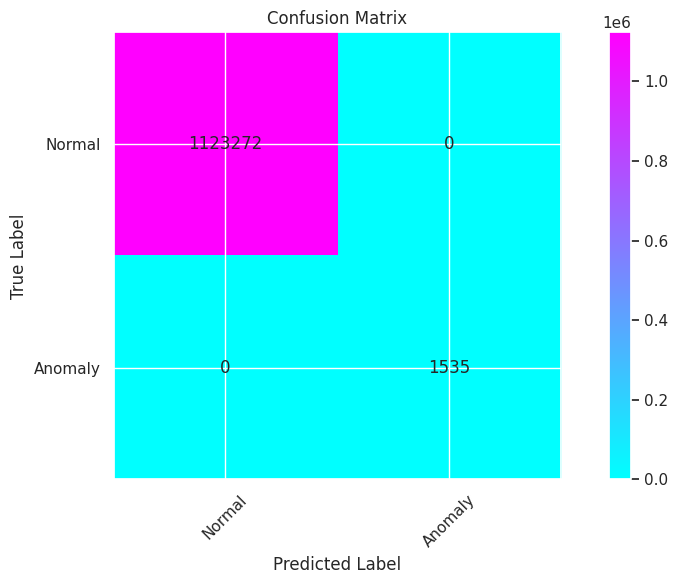

In [68]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)
plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/pyt_mlp_confusion_matrix.png')

In [69]:
import cudf
import pyarrow.parquet as pq
#!pip install librosa --user
#!pip install llvmlite --ignore-installed
#!pip install nvtabular==0.5.3
pyt_dl_time = time.time()

In [71]:
####### (GPU only) NVTabular Dataloader and Dataset
import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

if use_cpu:
    raise Exception('This section is for GPU only.')
        

/home/opc/miniconda3/lib/python3.11/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/opc/miniconda3/lib/python3.11/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [72]:
nvt.__version__

'23.08.00'

In [73]:
train = concat([X_train[sorted(X_train.columns)],  y_train], axis=1)
train[CATEGORICAL_COLUMNS] = train[CATEGORICAL_COLUMNS].astype(int16)
train.head()

,Channel,CoCreditScore,CreditScore,DTIRat,Extra,FTHomeBuyer,LoanPurpose,MortInsType,NumBorrow,NumUnits,OccStatus,OrCLTV,OrInterestRate,OrLoanTerm,OrUnpaidPrinc,ProductType,PropertyState,PropertyType,SellerName,Zip,Default
9095777,1,0.000193,0.752115,-0.813833,-0.000102,1,1,0,-1.166797,-0.132978,0,0.625094,-0.679839,0.640855,1.363902,0,12,1,3,16,0
5590064,0,1.013063,-0.130757,0.782411,-0.000102,0,1,0,0.816311,-0.132978,0,0.972869,0.420215,0.640855,0.284004,0,6,0,8,720,0
10990690,0,0.000193,0.668032,0.161650,-0.830916,0,1,0,-1.166797,-0.132978,0,1.378606,-1.290981,0.640855,0.114766,0,48,1,4,266,0
11239914,1,0.000193,0.000118,-0.000149,-0.000102,0,2,0,-0.000172,-0.000139,0,-0.000007,0.000047,0.000036,-0.000117,0,12,0,2,41,1
10886123,0,0.000193,0.983343,1.137132,-0.000102,0,2,0,-1.166797,-0.132978,0,-1.867293,-2.268807,-1.523394,-0.957073,0,24,0,27,439,0


In [74]:
test = concat([X_test[sorted(X_test.columns)],  y_test], axis=1)
test[CATEGORICAL_COLUMNS] = test[CATEGORICAL_COLUMNS].astype(cp.int16)
test.head()

,Channel,CoCreditScore,CreditScore,DTIRat,Extra,FTHomeBuyer,LoanPurpose,MortInsType,NumBorrow,NumUnits,OccStatus,OrCLTV,OrInterestRate,OrLoanTerm,OrUnpaidPrinc,ProductType,PropertyState,PropertyType,SellerName,Zip,Default
3902520,0,0.000193,-0.908525,-0.015711,-0.000102,0,2,0,-1.166797,-0.132978,0,0.045469,0.053530,0.640855,-1.045721,0,4,0,0,249,0
7687236,0,-1.950021,-0.088715,-0.370432,-0.000102,0,1,0,0.816311,-0.132978,1,0.625094,0.420215,0.640855,-0.916778,0,10,0,2,386,0
2931006,1,2.053294,1.403759,-1.079873,-0.000102,0,2,0,0.816311,-0.132978,0,-1.403593,-0.068698,-1.523394,-1.142428,0,13,0,2,27,0
432465,1,0.000193,-1.307919,-0.104391,-0.000102,0,1,0,-1.166797,-0.132978,0,1.494531,1.275813,0.640855,-0.272063,0,26,1,1,378,0
5609,0,0.000193,0.415783,0.516370,-0.000102,1,1,0,-1.166797,-0.132978,0,0.509169,1.886955,0.448477,0.509654,0,5,0,3,179,0


In [75]:
# for explainability later.
y_pos = y_test.loc[y_test==1].sample(n=BATCH_SIZE, random_state=8675309)
y_neg = y_test.loc[y_test==0].sample(n=BATCH_SIZE, random_state=8675309)

X_test_pos = X_test.loc[y_pos.index]
X_test_neg = X_test.loc[y_neg.index]

pos_data = concat([X_test_pos[sorted(X_test_pos.columns)],  y_pos], axis=1)
pos_data[CATEGORICAL_COLUMNS] = pos_data[CATEGORICAL_COLUMNS].astype(int16)

neg_data = concat([X_test_neg[sorted(X_test_neg.columns)],  y_neg], axis=1)
neg_data[CATEGORICAL_COLUMNS] = neg_data[CATEGORICAL_COLUMNS].astype(int16)

pos_path = f'{clean_data_path}/fnma_pos_test.parquet'
neg_path = f'{clean_data_path}/fnma_neg_test.parquet'

pos_data.to_parquet(pos_path)
neg_data.to_parquet(neg_path)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [76]:
# save train and test (not necessary but saves time from re-processing data if you restart kernel)

# train_path = 'fnma_train_nvt_ros.parquet'
# test_path = 'fnma_test_nvt_ros.parquet'

train_path = f'{clean_data_path}/fnma_train_nvt.parquet'
test_path = f'{clean_data_path}/fnma_test_nvt.parquet'

In [77]:
train.to_parquet(train_path)
test.to_parquet(test_path)

In [78]:
train_dataset = TorchAsyncItr(
    nvt.Dataset(train_path),
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_loader = DLDataLoader(
   train_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

test_dataset = TorchAsyncItr(
   nvt.Dataset(test_path),
   cats=CATEGORICAL_COLUMNS,
   conts=CONTINUOUS_COLUMNS,
   labels=LABEL_COLUMNS,
   batch_size=BATCH_SIZE
)

test_loader = DLDataLoader(
   test_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

TypeError: dataset() got an unexpected keyword argument 'metadata_collector'

In [79]:
###### Model Training - NVTabular Dataloader
model = binaryClassification(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)

print(model)
criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor(25, device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (prelu3): PReLU(num_parameters=1)
  (prelu4): PReLU(num_parameters=1)
  (prelu5): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, 

In [80]:
def binary_acc(y_pred, y_test):
    with torch.no_grad():
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
    return acc

model_name = 'fnma_model_mlp_nvt'

start = time.time()
max_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    train_loss, train_logits, train_targets = train_epoch(model, train_loader, optimizer, criterion, metric=binary_acc, device=device,
                             epoch=e)
    epoch_f1_score, threshold = calc_metrics(model, train_targets, train_logits, test_loader, criterion, device, use_cpu)
    if epoch_f1_score > max_f1:
        max_f1 = epoch_f1_score
        # save the model
        save_checkpoint(model, optimizer, e, epoch_f1_score, model_name, threshold=threshold, save_path=clean_data_path)
    
print(f'Total time: {time.time() - start}')

NameError: name 'train_loader' is not defined

In [81]:
model, threshold = load_checkpoint(model_name, model, device, save_path=clean_data_path)

FileNotFoundError: [Errno 2] No such file or directory: './rapids/notebooks/cleaned_data/checkpoints/fnma_model_mlp_nvt.pt'

In [82]:
# in sample performance.
_ = test_em(model, train_loader, criterion, threshold, device, use_cpu=use_cpu,
            save_path=f'{figures_path}/in_sample_nvt_mlp_pyt_pr_roc.png')

NameError: name 'train_loader' is not defined

In [83]:
# out of sample performance.
true_labels, pred_labels = test_em(model, test_loader, criterion, threshold, device, use_cpu=use_cpu,
                                   save_path=f'{figures_path}/out_of_sample_nvt_mlp_pyt_pr_roc.png')

NameError: name 'test_loader' is not defined

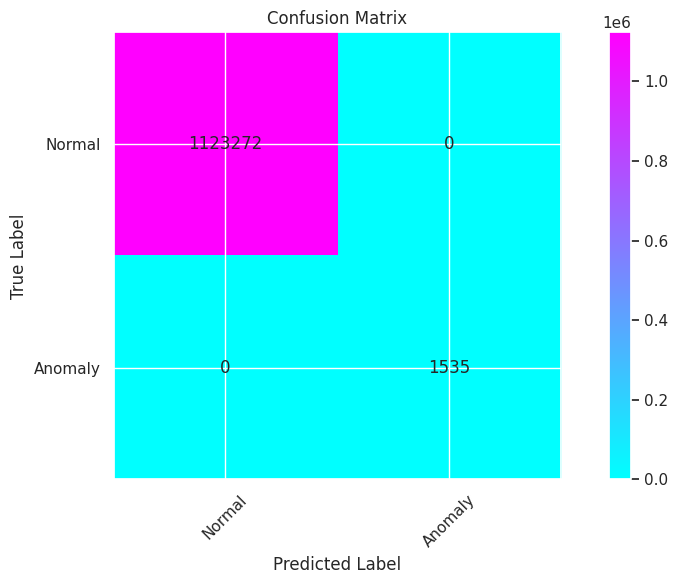

In [84]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)
plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/nvt_mlp_confusion_matrix.png')

In [85]:
####### Timings
nvt_time = time.time()

In [87]:
figures_path = './rapids/notebooks/figures'

In [88]:
import seaborn as sns
sns.set()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

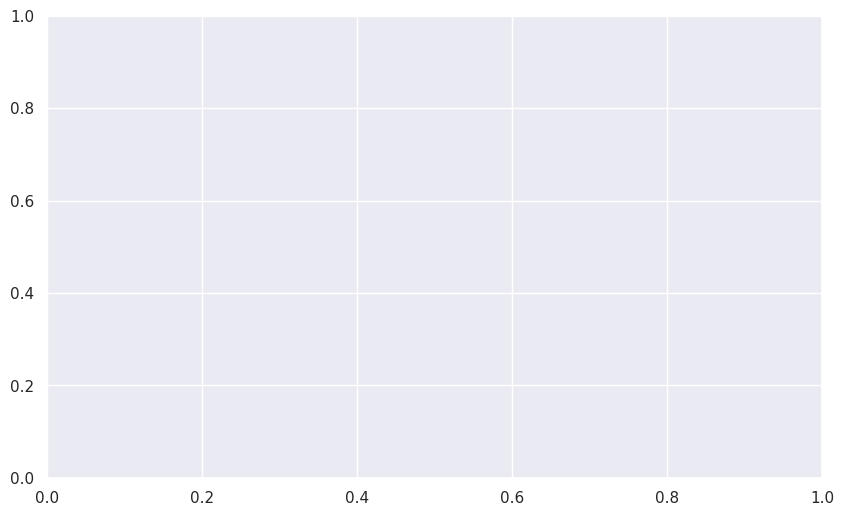

In [89]:
#Orig from Aug 2 2021:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Sep 2, 2020
data = [[614.2, 19.5, 125.9, .176, 1821.1, 9370.6, 27.7, 0.0, 504.0],
         [16.4, .137, 54.6, .007, 102.1, 3712.4, 4.3, 631.0, 254.9]]

steps = ['read_csv', 'merge', 'xgb train', 'xgb inference',
         'xgb shap', 'pyt train', 'pyt inference', 'nvtabular train\n(GPU only)',
         'captum\ngradientshap']
steps.reverse()
data[0].reverse()
data[1].reverse()
#data[2].reverse()
cpu = data[0]
a100 = data[1]
#a100 = data[2]
DF = pd.DataFrame({#'NVIDIA A100 GPU': a100,
                   'NVIDIA A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dict = {#"NVIDIA A100 GPU": "darkgreen",
    "NVIDIA A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dict.values(), ax=ax)
plt.suptitle("RAPIDS GPU Acceleration of read_csv, merge, ML training ML inference, and Shapley ML Explanation")
ax.set_title('Run times on CPU and GPU - Lower is better')
ax.set_xlabel('latency in seconds')

# print("               RAPIDS GPU Acceleration of read_csv, merge, ML training,")
# print("                       ML inference, and Shapley ML Explanation")

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

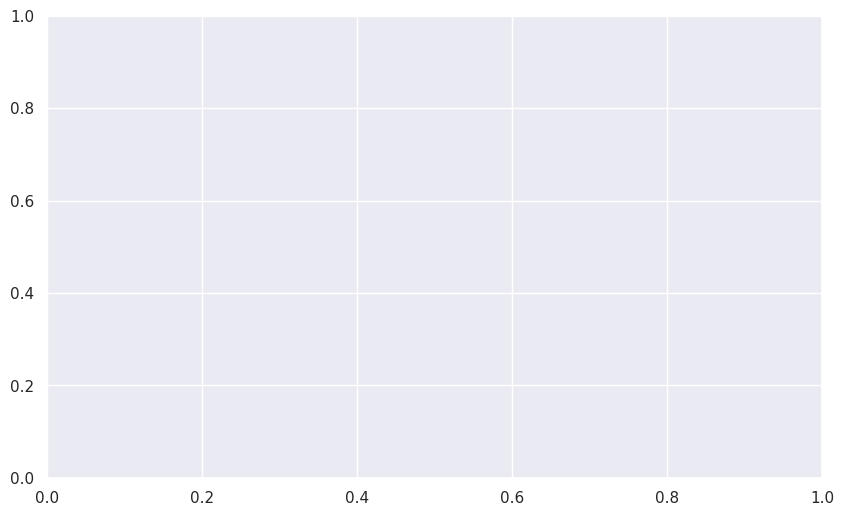

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Aug 2, 2021
data = [[614.2, 19.5, 27.7],
         [16.4, .137, 4.3]]

steps = ['read_csv','merge', 'pyt inference']

steps.reverse()
data[0].reverse()
data[1].reverse()
cpu = data[0]
a100 = data[1]
DF = pd.DataFrame({'NVIDIA Ampere A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dct = {"NVIDIA Ampere A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dct.values(), ax=ax)
ax.set_title('Run times on CPU and GPU')
ax.set_xlabel('latency in seconds')
plt.suptitle("                  RAPIDS GPU Acceleration of read_csv, merge, DL inference")
ax.legend(loc='lower right')
plt.tight_layout()
# print("                  RAPIDS GPU Acceleration of read_csv, merge, DL inference")
plt.savefig(f'{figures_path}/perf_plot_preprocess.png', dpi=600)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

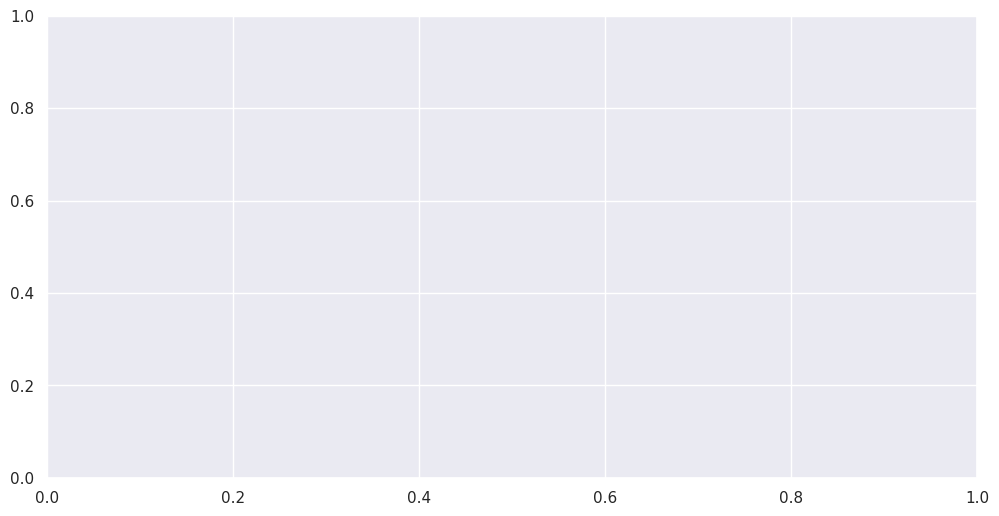

In [91]:
fig, ax = plt.subplots(figsize=(12,6))
#These timings are current as of Aug 2, 2021
data = [[125.9, 1821.1, 9370.6, 0.0, 504.0],
         [54.6, 102.1, 3712.4, 631.0, 254.9]]

steps = ['xgb train', 'xgb shap', 'pyt train', 'nvtabular train\n(GPU only)',
         'captum\ngradientshap']
steps.reverse()
data[0].reverse()
data[1].reverse()
cpu = data[0]
a100 = data[1]
DF = pd.DataFrame({'NVIDIA A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dct = {"NVIDIA Ampere A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dict.values(), ax=ax)
ax.set_title('Run times on CPU and GPU')
ax.set_xlabel('latency in seconds')
plt.suptitle("                  RAPIDS GPU Acceleration of ML and DL train, NVTabular train, and Shapley ML and DL Explanation")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{figures_path}/perf_plot_train.png', dpi=800)
# print("    RAPIDS GPU Acceleration of ML and DL train, NVTabular train, and Shapley ML and DL Explanation")


ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

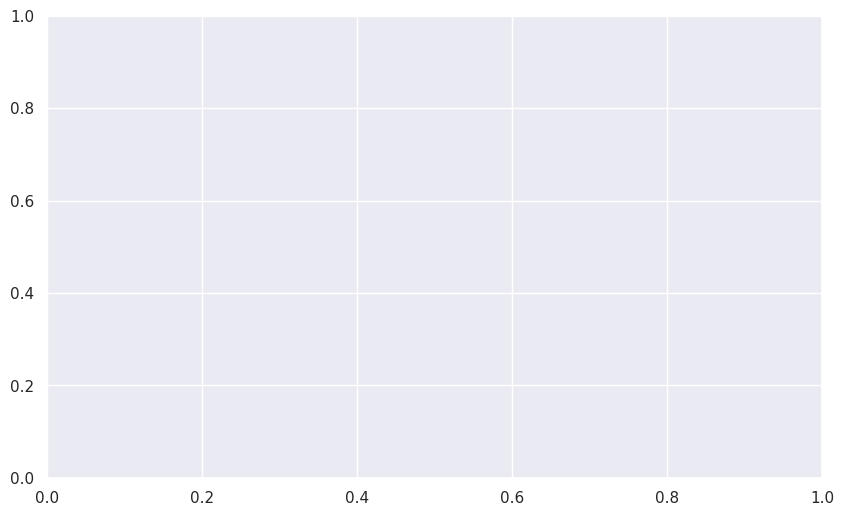

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Aug 2, 2021
data = [[382.2], [2567.3]]

# steps = ['xgb train', 'xgb shap', 'pyt train', 'nvtabular train\n(GPU only)',
#          'captum\ngradientshap']
# steps.reverse()
# data[0].reverse()
# data[1].reverse()
nvt_a100 = data[0]
pyt_a100 = data[1]
DF = pd.DataFrame({'PyTorch via NVTabular API on GPU': nvt_a100, 'PyTorch on GPU': pyt_a100},
                  index=['training\nepoch\nloop'],
                 )
color_dict = {"PyTorch via NVTabular API on GPU":  "#76B900", "PyTorch on GPU": "pink"}
_ = DF.plot.barh(color=color_dict.values(), ax=ax)
ax.set_title('Model train times with and without NVTabular on GPU')
ax.set_xlabel('latency in seconds')
# ax.set_ylabel('training\nepoch\nloop', rotation=0)
# plt.suptitle("                  Train times with and without NVTabular on GPU")
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.tight_layout()
plt.savefig(f'{figures_path}/perf_plot_nvt_train.png', dpi=600)

# fig.subplots_adjust()

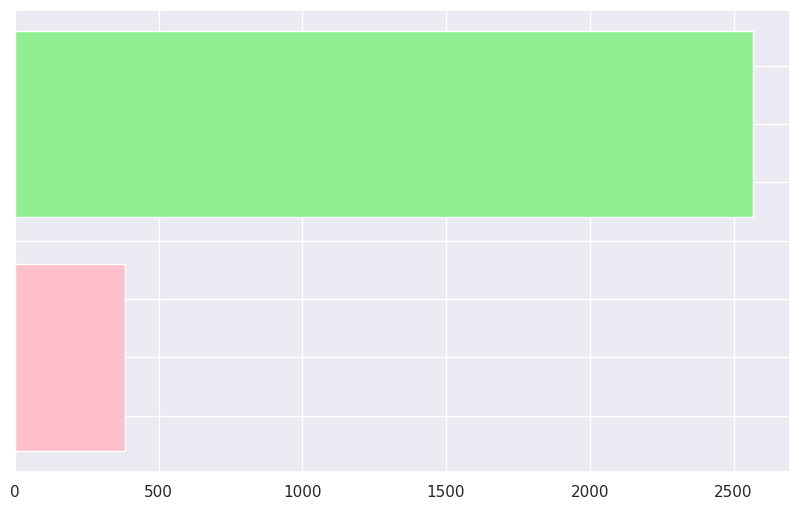

In [93]:
DF
pyt_a100
fig, ax = plt.subplots()
ax.barh(y=[0,1], width=[nvt_a100[0], pyt_a100[0]], color=['pink', 'lightgreen'])
_=ax.set_yticklabels([])

In [94]:
# total run time
print(nvt_time - total_start )

1084.197143316269


In [ ]:
cum_time = [i - total_start for i in [data_prep_time, shap_time, pyt_time, pyt_data_prep_time, pyt_dl_time, nvt_time]]
print(cum_time)

In [ ]:
#  Tested on n a A100 32 GB GPU CUDA 11.2 Driver 460.32.03 on July 16, 2021
# gpu_cum_time = [5.847876310348511, 77.14555883407593, 345.10619354248047, 347.9490294456482, 2602.528173685074, 2990.594742298126]